In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
# pip list

In [ ]:
pip install -r requirements.in --quiet

In [ ]:
pip uninstall dea_tools -y

In [ ]:
pip install -e /home/jovyan/Robbi/dea-notebooks/Tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


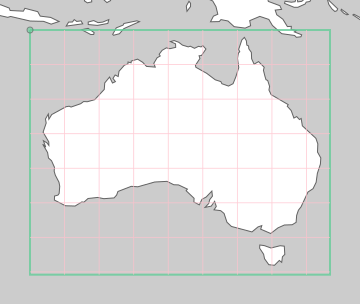

In [29]:
%load_ext autoreload
%autoreload 2

from odc.geo.xr import xr_zeros
from odc.geo.geobox import GeoBox
from dea_tools.coastal import pixel_tides
import pandas as pd

# Shoalwater
geobox = GeoBox.from_bbox(
   (1774502, -2581213, 1842016, -2464220
   ),  # minx, miny, maxx, maxy
   "epsg:3577", resolution=30)

# Roebuck
geobox = GeoBox.from_bbox(
   (-1073261, -2005741, -1002524, -1901300
   ),  # minx, miny, maxx, maxy
   "epsg:3577", resolution=60)

# Pilbara
geobox = GeoBox.from_bbox(
   (-1373261, -2305741, -672524, -1501300
   ),  # minx, miny, maxx, maxy
   "epsg:3577", resolution=500)

# Australia
geobox = GeoBox.from_bbox(
   (111.52, -44.91, 154.81, -9.69
   ),  # minx, miny, maxx, maxy
   "epsg:4326", resolution=0.1)

geobox

In [104]:
ds = xr_zeros(geobox)
times = pd.date_range("2020-01-01", "2020-01-02", freq="2h")

Creating reduced resolution 0.5 x 0.5 degree tide modelling array
Modelling tides with TPXO9-atlas-v5
Modelling tides with FES2014
Modelling tides with FES2012
Modelling tides with EOT20
Modelling tides with HAMTIDE11
Modelling tides with GOT4.10
Returning low resolution tide array


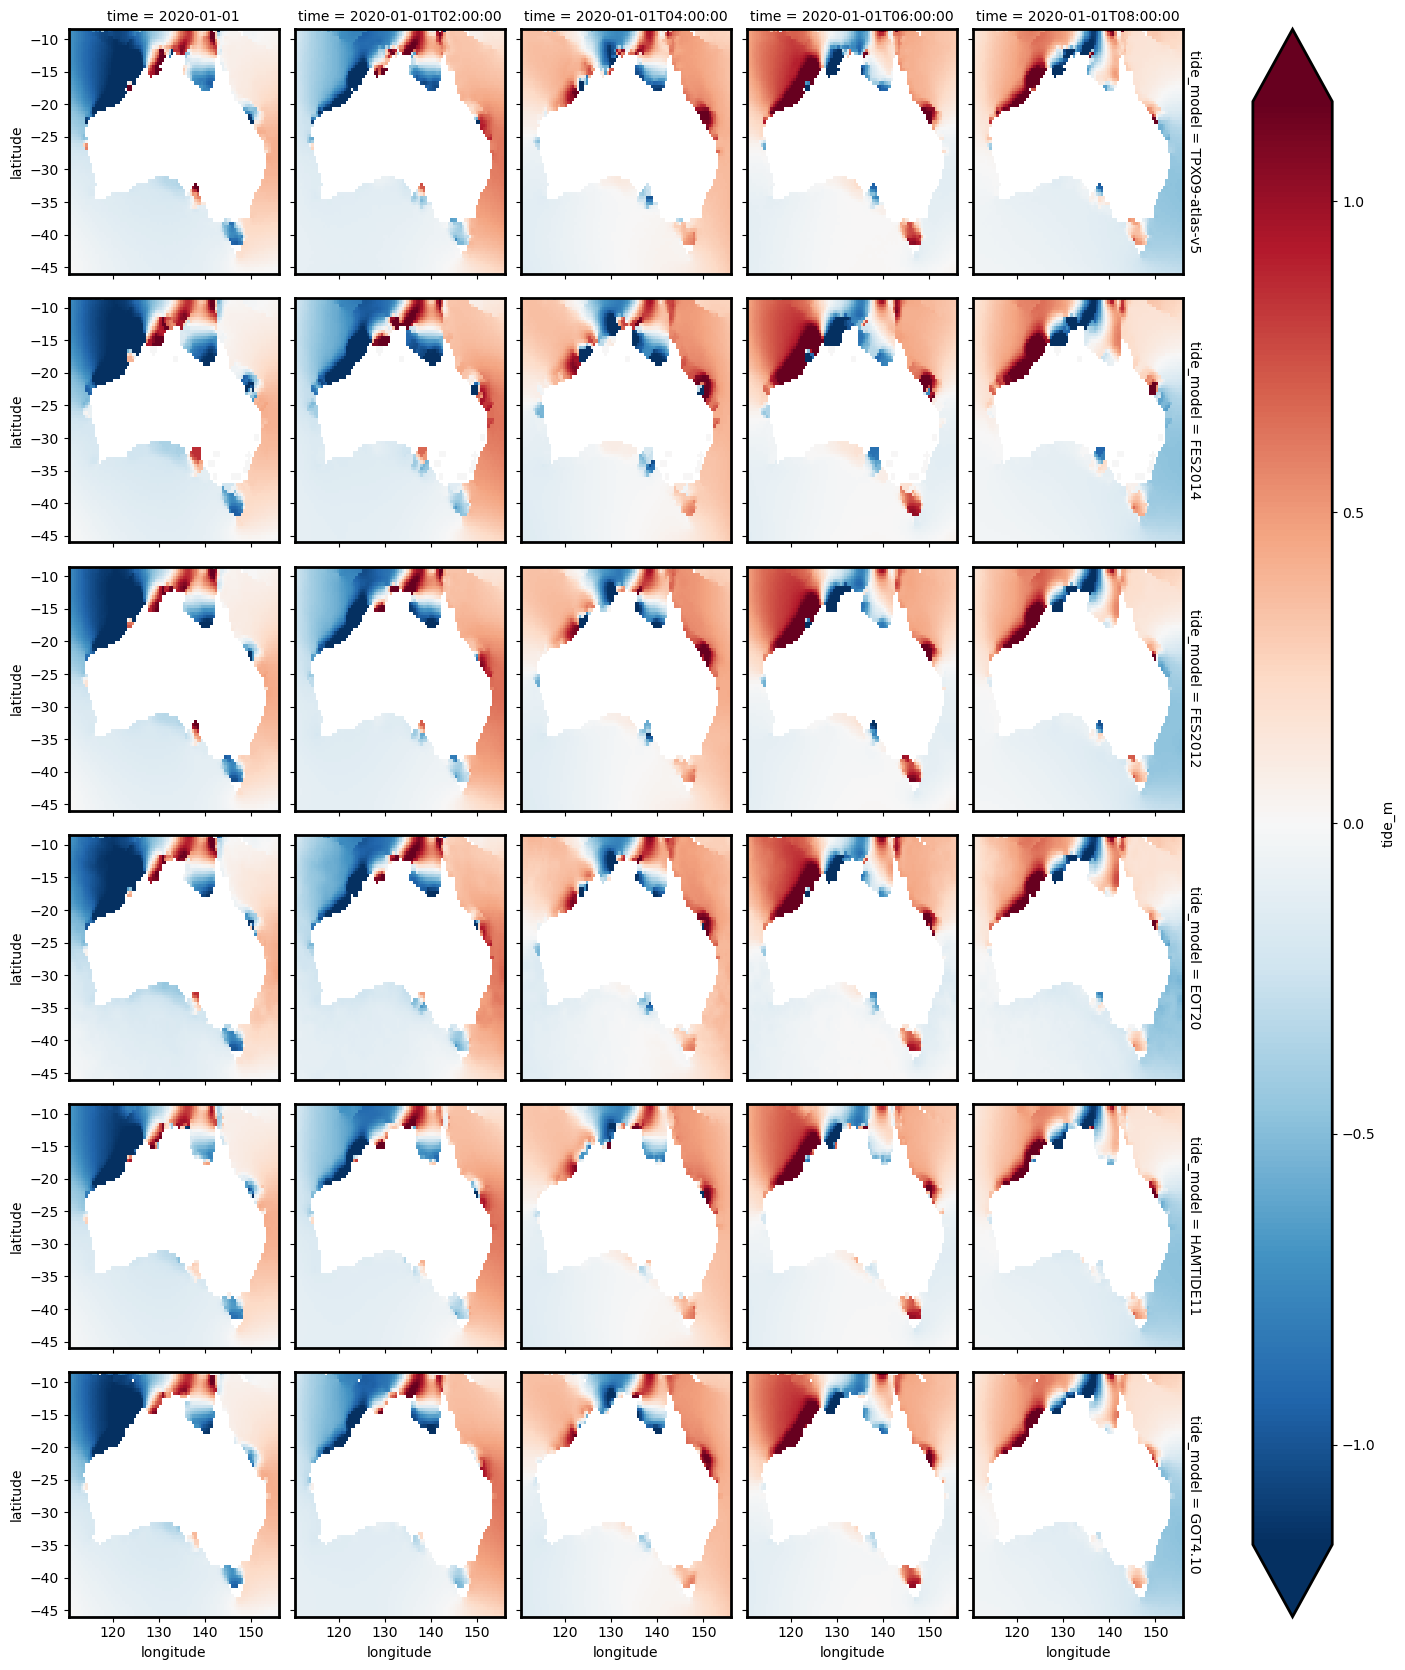

In [105]:
import datacube
import odc.geo.xr
import pandas as pd
from dea_tools.coastal import pixel_tides

tides_lowres = pixel_tides(
    ds=ds,
    times=times,
    model=[
        "TPXO9-atlas-v5",
        "FES2014",  # Aviso+
        "FES2012",  # Aviso+
        "EOT20",  # CC BY 4.0
        "HAMTIDE11",
        "GOT4.10",
        
    ],
    resolution=0.5,
    buffer=1,
    directory="~/tide_models_clipped/",
    resample=False,
    cutoff=50,
)

tides_lowres.isel(time=[0, 1, 2, 3, 4]).plot.imshow(col="time", row="tide_model", size=2.8, robust=True)

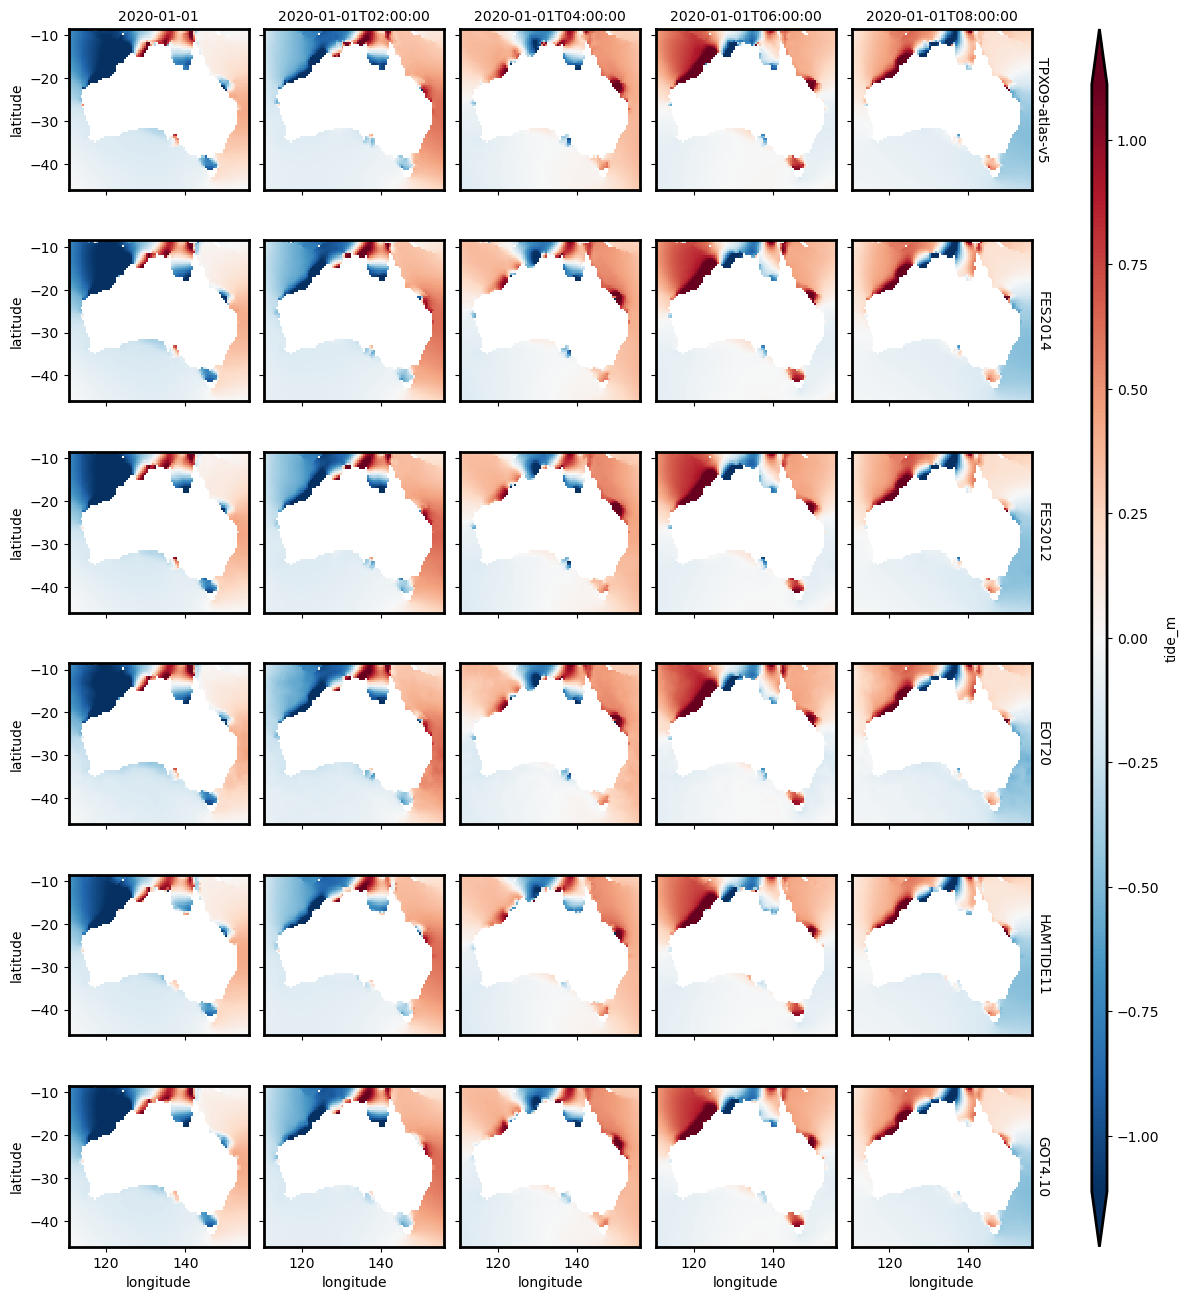

In [153]:
all_data_mask = ~tides_lowres.isnull().any(dim=["tide_model", "time"])
im = tides_lowres.where(all_data_mask).isel(time=[0, 1, 2, 3, 4]).plot(col="time", row="tide_model", robust=True, add_labels=False, center=0, size=2.2, aspect=1.1, cbar_kwargs={"aspect": 80})
im.set_titles(template="{value}")
plt.savefig("tide_models.jpg")



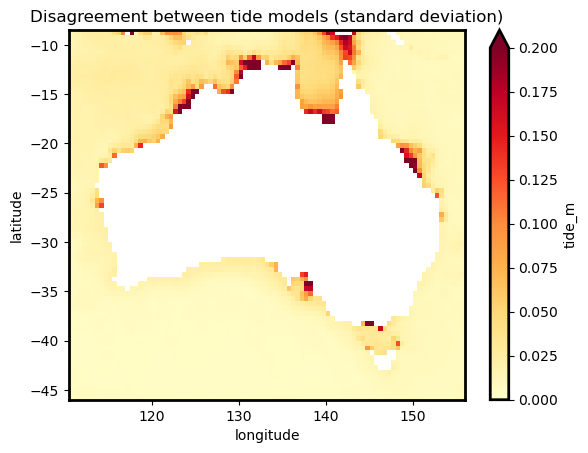

In [164]:
tides_lowres.where(all_data_mask).std(dim="tide_model").mean(dim="time").plot(vmin=0, vmax=0.2, cmap="YlOrRd")
plt.title("Disagreement between tide models (standard deviation)")
plt.savefig("tide_models_disagreement.jpg")


In [82]:

import datacube
from sklearn.decomposition import PCA

# import sys
# sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
from dea_tools.classification import sklearn_flatten, sklearn_unflatten

ds2 = tides_lowres.where(all_data_mask).mean("tide_model").to_dataset("time").rename(longitude="x", latitude="y")
x = sklearn_flatten(ds2)
pca = PCA(n_components=3)
pca.fit(x)

PCA(n_components=3)

In [83]:
print('Relative variance in principal components:',
      pca.explained_variance_ratio_)

Relative variance in principal components: [0.70106703 0.2780045  0.02042217]


In [84]:
predict = pca.transform(x)
out = sklearn_unflatten(predict, ds2)
out = out.to_dataset(dim=out.dims[0]).transpose(..., 'y', 'x')

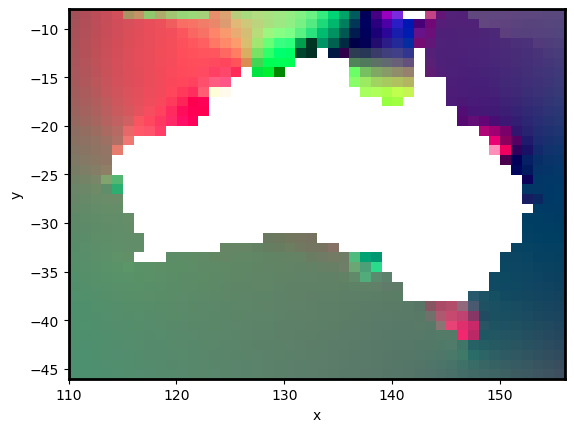

In [85]:
out.to_array().plot.imshow(robust=True)